# calculate $z_{\rm max}$ and additional values

In [1]:
import os
import h5py 
import glob
import numpy as np
from scipy.interpolate import interp1d

In [2]:
from astropy import units as U
from astropy.cosmology import Planck13

In [3]:
from provabgs import util as UT
from provabgs import infer as Infer
from provabgs import models as Models

In [4]:
from speclite import filters as specFilter

In [5]:
# -- plotting -- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False


Bad key text.latex.preview in file /global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key mathtext.fallback_to_cm in file /global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.jpeg_quality in file /global/homes/c/chahah/.conda/envs/gqp/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 418 ('savefig.jpeg_quality: 95 

## read in posteriors for `provabgs` healpix runs and calculate $z_{\rm max}$ for $\theta_{\rm bf}$

In [6]:
dat_dir = '/global/cfs/cdirs/desi/users/chahah/provabgs/svda/'

In [7]:
r_pass = specFilter.load_filters('decam2014-r')

def r_mag(w, f):
    ''' calculate r-band magnitude given w, f
    '''
    flux_z, w_z = r_pass.pad_spectrum(np.atleast_2d(f) * 1e-17*U.erg/U.s/U.cm**2/U.Angstrom, w * U.Angstrom)
    maggies = r_pass.get_ab_maggies(flux_z, wavelength=w_z)
    return 22.5 - 2.5 * np.log10(maggies.as_array()[0][0] * 1e9)

In [8]:
m_nmf = Models.NMF(burst=True, emulator=True)

input parameters : logmstar, beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh, fburst, tburst, gamma1_zh, gamma2_zh, dust1, dust2, dust_index


# BGS Bright

In [9]:
hpixs = [int(f.split('-')[3].split('.')[0]) for f in glob.glob(os.path.join(dat_dir, 'provabgs-*.BGS_BRIGHT.hdf5'))]
print('%i healpixels' % len(hpixs))

369 healpixels


In [10]:
mstars, zmaxes = [], [] 
for hpix in hpixs: 
    fpost = h5py.File(os.path.join(dat_dir, 'provabgs-sv3-bright-%i.BGS_BRIGHT.hdf5' % hpix), 'r')
    
    if 'redshift' not in fpost.keys(): 
        print()
        print('%i is problematic' % hpix)
        print()
        continue
        
    zreds = fpost['redshift'][...]
    if len(zreds) == 0: continue
        
    _logp = fpost['log_prob'][...]
    _logp = _logp.reshape((_logp.shape[0], _logp.shape[1] * _logp.shape[2]))
    
    _theta = fpost['samples'][...]
    _theta = _theta.reshape((_theta.shape[0], _theta.shape[1] * _theta.shape[2], _theta.shape[3]))
    
    theta_bfs = np.array([tt[imax,:] for imax, tt in zip(np.argmax(_logp, axis=1), _theta)])
    
    fpost.close() 
    
    mstar = np.zeros(len(zreds))
    zmax = np.zeros(len(zreds))
    for i, zred, theta_bf in zip(np.arange(len(zreds)), zreds, theta_bfs): 
        z_arr = np.linspace(zred, 0.6, 10)
        dlz = Planck13.luminosity_distance(z_arr).to(U.cm).value
        
        # get best-fit SED 
        w, f = m_nmf.sed(theta_bf[:-1], zred)
        # scale by f_fiber
        f /= theta_bf[-1]
        
        mstar[i] = theta_bf[0]
    
        r_arr = []
        for _z, _dlz in zip(z_arr, dlz):
            w_z = w / (1. + zred) * (1 + _z)
            f_z = f * (dlz[0]**2 / _dlz**2) * (1 + zred)/(1 + _z)

            r_arr.append(r_mag(w_z, f_z))

        if np.min(r_arr) > 19.5:
            zmax[i] = zred
        elif np.max(r_arr) < 19.5:
            zmax[i] = 0.6
        else:
            fint_rz = interp1d(r_arr, z_arr, kind='cubic')
            zmax[i] = fint_rz(19.5)
            
    mstars.append(mstar)
    zmaxes.append(zmax)
    
    fpost = h5py.File(os.path.join(dat_dir, 'provabgs-sv3-bright-%i.BGS_BRIGHT.hdf5' % hpix), 'r+')
    if 'zmax' in fpost.keys(): 
        fpost['zmax'][...] = zmax
    else: 
        fpost.create_dataset('zmax', data=zmax)
    if 'theta_bf' in fpost.keys(): 
        fpost['theta_bf'][...] = theta_bfs
    else: 
        fpost.create_dataset('theta_bf', data=theta_bfs)
    fpost.close()
    
mstars = np.concatenate(mstars)
zmaxes = np.concatenate(zmaxes)


9932 is problematic



(7.0, 13.0)

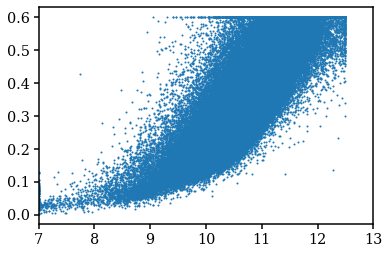

In [11]:
plt.scatter(mstars, zmaxes, s=1)
plt.xlim(7., 13.)

# BGS Faint

In [12]:
hpixs = [int(f.split('-')[3].split('.')[0]) for f in glob.glob(os.path.join(dat_dir, 'provabgs-*.BGS_FAINT.hdf5'))]
print('%i healpixels' % len(hpixs))

360 healpixels


In [13]:
mstars, zmaxes = [], [] 
for hpix in hpixs: 
    fpost = h5py.File(os.path.join(dat_dir, 'provabgs-sv3-bright-%i.BGS_FAINT.hdf5' % hpix), 'r')
    
    #if 'zmax' in fpost.keys(): continue 
    if 'redshift' not in fpost.keys(): 
        print()
        print('%i is problematic' % hpix)
        print()
        continue
        
    zreds = fpost['redshift'][...]
    if len(zreds) == 0: continue
        
    _logp = fpost['log_prob'][...]
    _logp = _logp.reshape((_logp.shape[0], _logp.shape[1] * _logp.shape[2]))
    
    _theta = fpost['samples'][...]
    _theta = _theta.reshape((_theta.shape[0], _theta.shape[1] * _theta.shape[2], _theta.shape[3]))
    
    theta_bfs = np.array([tt[imax,:] for imax, tt in zip(np.argmax(_logp, axis=1), _theta)])
    
    fpost.close() 
    
    mstar = np.zeros(len(zreds))
    zmax = np.zeros(len(zreds))
    for i, zred, theta_bf in zip(np.arange(len(zreds)), zreds, theta_bfs): 
        z_arr = np.linspace(zred, 0.6, 10)
        dlz = Planck13.luminosity_distance(z_arr).to(U.cm).value
        
        # get best-fit SED 
        w, f = m_nmf.sed(theta_bf[:-1], zred)
        # scale by f_fiber
        f /= theta_bf[-1]
        
        mstar[i] = theta_bf[0]
    
        r_arr = []
        for _z, _dlz in zip(z_arr, dlz):
            w_z = w / (1. + zred) * (1 + _z)
            f_z = f * (dlz[0]**2 / _dlz**2) * (1 + zred)/(1 + _z)

            r_arr.append(r_mag(w_z, f_z))

        if np.min(r_arr) > 19.5:
            zmax[i] = zred
        elif np.max(r_arr) < 19.5:
            zmax[i] = 0.6
        else:
            fint_rz = interp1d(r_arr, z_arr, kind='cubic')
            zmax[i] = fint_rz(19.5)
            
    mstars.append(mstar)
    zmaxes.append(zmax)
    
    fpost = h5py.File(os.path.join(dat_dir, 'provabgs-sv3-bright-%i.BGS_FAINT.hdf5' % hpix), 'a')
    fpost.create_dataset('zmax', data=zmax)
    fpost.create_dataset('theta_bf', data=theta_bfs)
    fpost.close()
    
mstars = np.concatenate(mstars)
zmaxes = np.concatenate(zmaxes)

(7.0, 13.0)

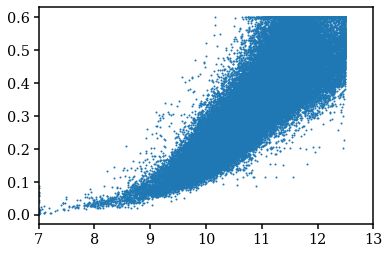

In [14]:
plt.scatter(mstars, zmaxes, s=1)
plt.xlim(7., 13.)